In [1]:
from enum import Enum
import hashlib
import math
import os
import random
import re

#from chainmap import ChainMap
from scipy.io import wavfile
from scipy import signal

import librosa
import pandas as pd
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# audio_file='C:/Projects/kaggle/speech/train/audio/silence/empty.wav'

# duration   = 1
# sample_rate = 16000 #22050

# wave = np.zeros(duration*sample_rate, np.float32)
# wavfile.write(audio_file,sample_rate,wave)

## preporcess 

In [3]:
AUDIO_DIR = 'C:/Projects/kaggle/speech'
AUDIO_NUM_CLASSES = 12
AUDIO_NAMES =[ 'silence', 'unknown', 'yes', 'no', 'up', 
              'down', 'left', 'right', 'on', 'off', 'stop', 'go']
AUDIO_SR = 16000
AUDIO_LENGTH = 16000

In [4]:
label_to_name = dict(zip(list(range(AUDIO_NUM_CLASSES)), AUDIO_NAMES))
name_to_label = dict(zip( AUDIO_NAMES,list(range(AUDIO_NUM_CLASSES))))

In [5]:
def read_list_from_file(list_file, comment='#', func=None):
    with open(list_file) as f:
        lines  = f.readlines()

    strings=[]
    for line in lines:
        s = line.split(comment, 1)[0].strip()
        if s != '':
            strings.append(s)
    if func is not None:
        strings=[func(s) for s in strings]

    return strings

In [6]:
known_probability = 0.8
silence_probability = 0.1
unknown_probability = 0.1

## Train/Test Set List

In [7]:
def get_train_test_list(split,mode,settype):
    num_classes = len(AUDIO_NAMES)
    ids=[]
    labels=[]
    index_by_class=[]
    
    lines = read_list_from_file(AUDIO_DIR + '/split/' + split, comment='#')
    for line in lines:
        ids.append(line)

    if mode in ['train']:
        for line in lines:
            name = line.split('/')[2]
            if name not in AUDIO_NAMES:
                #continue
                name='unknown'
            labels.append(name_to_label[name])

        for i in range(num_classes):
            index =np.where(np.array(labels)==i)[0]
            index_by_class.append(list(index))
    known_num = 0
    for i in range(2,AUDIO_NUM_CLASSES):
        known_num += len(index_by_class[i])
    silence_num = int(known_num/known_probability*silence_probability)
    unknown_num = int(known_num/known_probability*unknown_probability)
    ##silence list
    silence_list  = ['train/audio/silence/silence.wav']*silence_num
    ##unknow list
    unknown_list = index_by_class[1]
    random.shuffle(unknown_list)
    unknown_list = unknown_list[:unknown_num]
    unknown_list = [ ids[i] for i in unknown_list]
    ##know list
    known_list = []
    for i in range(2,AUDIO_NUM_CLASSES):
        known_list +=  index_by_class[i]
    known_list = [ ids[i] for i in known_list]
    
    ##
    final_list = silence_list + unknown_list + known_list
    if settype in ['train']:
        random.shuffle(final_list)
    
    return final_list

In [8]:
# split='train_train_51088.txt'
# mode = 'train'
# settype = 'train'
# train_list=get_train_test_list(split,mode,settype)

In [9]:
#len(train_list)

In [10]:
#len(test_list)

In [11]:
AUDIO_NOISES=[]
for file in ['dude_miaowing.wav',  'pink_noise.wav',   'white_noise.wav', 'doing_the_dishes.wav',
             'exercise_bike.wav',  'running_tap.wav']:
    audio_file = AUDIO_DIR + '/train/audio/_background_noise_/' + file
    wave = librosa.core.load(audio_file, sr=AUDIO_SR)[0]
    AUDIO_NOISES.append(wave)

In [12]:
def tf_random_add_noise_transform(wave, noise_limit=0.2, u=0.5):

    if random.random() < u:
        num_noises = len(AUDIO_NOISES)
        noise = AUDIO_NOISES[np.random.choice(num_noises)]

        wave_length  = len(wave)
        noise_length = len(noise)
        t = np.random.randint(0, noise_length - wave_length - 1)
        noise = noise[t:t + wave_length]

        alpha = np.random.random() * noise_limit
        wave  = np.clip(alpha * noise + wave, -1, 1)

    return wave


def tf_random_time_shift_transform(wave, shift_limit=0.2, u=0.5):
    if random.random() < u:
        wave_length  = len(wave)
        shift_limit = shift_limit*wave_length
        shift = np.random.randint(-shift_limit, shift_limit)
        t0 = -min(0, shift)
        t1 =  max(0, shift)
        wave = np.pad(wave, (t0, t1), 'constant')
        wave = wave[:-t0] if t0 else wave[t1:]

    return wave


def tf_random_pad_transform(wave, length=AUDIO_LENGTH):

    if len(wave)<AUDIO_LENGTH:
        L = abs(len(wave)-AUDIO_LENGTH)
        start = np.random.choice(L)
        wave  = np.pad(wave, (start, L-start), 'constant')

    elif len(wave)>AUDIO_LENGTH:
        L = abs(len(wave)-AUDIO_LENGTH)
        start = np.random.choice(L)
        wave  = wave[start: start+AUDIO_LENGTH]

    return wave

def tf_fix_pad_transform(wave, length=AUDIO_LENGTH):
    # wave = np.pad(wave, (0, max(0, AUDIO_LENGTH - len(wave))), 'constant')
    # return wave

    if len(wave)<AUDIO_LENGTH:
        L = abs(len(wave)-AUDIO_LENGTH)
        start = L//2
        wave  = np.pad(wave, (start, L-start), 'constant')

    elif len(wave)>AUDIO_LENGTH:
        L = abs(len(wave)-AUDIO_LENGTH)
        start = L//2
        wave  = wave[start: start+AUDIO_LENGTH]

    return wave

In [13]:
def tf_wave_to_mfcc(wave):

    spectrogram = librosa.feature.melspectrogram(wave, sr=AUDIO_SR, n_mels=40, hop_length=160, n_fft=480, fmin=20, fmax=4000)
    #spectrogram = librosa.power_to_db(spectrogram)
    idx = [spectrogram > 0]
    spectrogram[idx] = np.log(spectrogram[idx])

    dct_filters = librosa.filters.dct(n_filters=40, n_input=40)
    mfcc = [np.matmul(dct_filters, x) for x in np.split(spectrogram, spectrogram.shape[1], axis=1)]
    mfcc = np.hstack(mfcc)
    mfcc = mfcc.astype(np.float32)

    return mfcc


def tf_wave_to_melspectrogram(wave):
    spectrogram = librosa.feature.melspectrogram(wave, sr=AUDIO_SR, n_mels=40, hop_length=160, n_fft=480, fmin=20, fmax=4000)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)

    return spectrogram

def log_specgram(audio, sample_rate=16000, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    _, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)

In [14]:
def train_augment(wave):
    wave = tf_random_time_shift_transform(wave, shift_limit=0.2, u=0.5)
    wave = tf_random_add_noise_transform (wave, noise_limit=0.2, u=0.5)
    wave = tf_random_pad_transform(wave)

    #tensor = tf_wave_to_melspectrogram(wave)[np.newaxis,:]
    #tensor = tf_wave_to_mfcc(wave).reshape(40,101,1)
    #tensor = tf_wave_to_melspectrogram(wave).reshape(40,101,1)
    tensor = log_specgram(wave).reshape(99,161,1)
    #tensor = torch.from_numpy(tensor)
    return tensor


def valid_augment(wave):
    wave = tf_fix_pad_transform(wave)

    #tensor = tf_wave_to_melspectrogram(wave)[np.newaxis,:]
    #tensor = tf_wave_to_mfcc(wave).reshape(40,101,1)
    #tensor = tf_wave_to_melspectrogram(wave).reshape(40,101,1)
    tensor = log_specgram(wave).reshape(99,161,1)
    #tensor = torch.from_numpy(tensor)
    return tensor

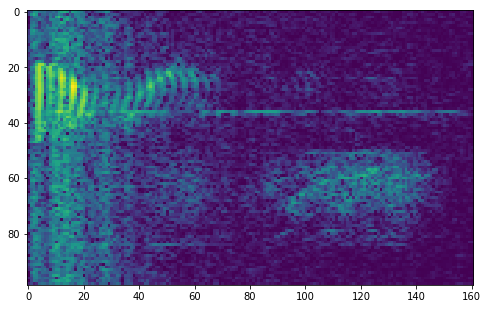

In [15]:
audio_file = r'C:\Projects\kaggle\speech\train\audio\yes\00f0204f_nohash_0.wav'
wave = librosa.core.load(audio_file, sr=AUDIO_SR)[0]
res= train_augment(wave)
fig=plt.figure(figsize=(8, 14))
ax2 = fig.add_subplot(212)
ax2.imshow(res[:,:,0])

## Generate Train Test Data

In [16]:
label_cat={}
for i in range(0,len(AUDIO_NAMES)):
    tmp=np.zeros((len(AUDIO_NAMES)))
    tmp[i]=1
    label_cat[AUDIO_NAMES[i]]=tmp

In [17]:
def train_generator(batch_size):
    split='train_train_51088.txt'
    train_list=get_train_test_list(split,'train','train')
    L = len(train_list)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X=[]
            Y=[]
            for file in train_list[batch_start:limit]:
                ## label
                label = file.split('/')[2]
                if label not in AUDIO_NAMES:
                    label = 'unknown'
                Y.append(label_cat[label])
                ## mfcc
                if label in ['silence']:
                    wave = np.zeros(1*AUDIO_SR, np.float32)
                else:
                    audio_file = AUDIO_DIR + '/'+ file
                    wave = librosa.core.load(audio_file, sr=AUDIO_SR)[0]
                mfcc_tmp = train_augment(wave)
                X.append(mfcc_tmp) 
        
            yield np.array(X),np.array(Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [18]:
def valid_generator(batch_size):
    split='train_test_6835.txt'
    valid_list=get_train_test_list(split,'train','test')
    L = len(valid_list)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X=[]
            Y=[]
            for file in valid_list[batch_start:limit]:
                ## label
                label = file.split('/')[2]
                if label not in AUDIO_NAMES:
                    label = 'unknown'
                Y.append(label_cat[label])
                ## mfcc
                if label in ['silence']:
                    wave = np.zeros(1*AUDIO_SR, np.float32)
                else:
                    audio_file = AUDIO_DIR + '/'+ file
                    wave = librosa.core.load(audio_file, sr=AUDIO_SR)[0]
                mfcc_tmp = valid_augment(wave)
                X.append(mfcc_tmp) 
        
            yield np.array(X),np.array(Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [19]:
# def generate_traintest_data(file_list):
#     X = []
#     Y = []
#     for file in train_list:
#         ## label
#         label = file.split('/')[2]
#         if label not in AUDIO_NAMES:
#             label = 'unknown'
#         Y.append(label_cat[label])
#         ## mfcc
#         if label in ['silence']:
#             wave = np.zeros(1*AUDIO_SR, np.float32)
#         else:
#             audio_file = AUDIO_DIR + '/'+ file
#             wave = librosa.core.load(audio_file, sr=AUDIO_SR)[0]
#         mfcc_tmp = train_augment(wave)
#         X.append(mfcc_tmp)
    
#     return np.array(X),np.array(Y)
    

In [20]:
# split='train_test_6835.txt'
# mode = 'train'
# settype = 'test'
# valid_list=get_train_test_list(split,mode,settype)
# len(valid_list)

## Keras CNN Model

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
                         Dropout,BatchNormalization,Activation
from keras import initializers
from keras import optimizers
###
model = Sequential()
model.add(BatchNormalization(input_shape=(99, 161, 1)))
### conv 1a
model.add(Conv2D(16, 
                 kernel_size = (3, 3),
                 padding='same',
                ))
model.add(BatchNormalization())
model.add(Activation('relu'))
### conv 1b
model.add(Conv2D(16, 
                 kernel_size = (3, 3),
                 padding='same',
                ))
model.add(BatchNormalization())
model.add(Activation('relu'))
### pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
### conv 2a
model.add(Conv2D(32, 
                 kernel_size = (3, 3),
                 padding='same',
                ))
model.add(BatchNormalization())
model.add(Activation('relu'))
### conv 2b
model.add(Conv2D(32, 
                 kernel_size = (3, 3),
                 padding='same',
                ))
model.add(BatchNormalization())
model.add(Activation('relu'))
### pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
### conv 3a
model.add(Conv2D(64, 
                 kernel_size = (3, 3),
                 padding='same',
                ))
### conv 3b
model.add(Conv2D(64, 
                 kernel_size = (3, 3),
                 padding='same',
                ))
model.add(BatchNormalization())
model.add(Activation('relu'))
### pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
### conv 4a
model.add(Conv2D(128, 
                 kernel_size = (3, 3),
                 padding='same',
                ))
### conv 4b
model.add(Conv2D(128, 
                 kernel_size = (3, 3),
                 padding='same',
                ))
model.add(BatchNormalization())
model.add(Activation('relu'))
### pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
### hidden
model.add(Flatten())
model.add(Dense(512)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
### linear
model.add(Dense(256,activation = 'relu')) 
## softmax
model.add(Dense(len(AUDIO_NAMES), 
                activation = 'softmax')) #Last layer with one output per class

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adagrad(),#optimizers.SGD(lr=0.001, decay=1e-5, momentum=0.9, nesterov=True), 
              metrics=["accuracy"])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 99, 161, 1)        4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 161, 16)       160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 99, 161, 16)       64        
_________________________________________________________________
activation_1 (Activation)    (None, 99, 161, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 99, 161, 16)       2320      
_________________________________________________________________
batch_normalization_3 (Batch (None, 99, 161, 16)       64        
_________________________________________________________________
activation_2 (Activation)    (None, 99, 161, 16)       0         
__________

## Run model

In [22]:
from keras.callbacks import EarlyStopping

In [23]:
##### define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]
##
# model.fit(X_train, Y_train, 
#           batch_size=128, epochs=100, #callbacks=callbacks_list,
#           validation_data=(X_valid, Y_valid),
#           verbose=1)
batch_size=128
history = model.fit_generator(generator=train_generator(batch_size),
                              steps_per_epoch=np.ceil(23172 / batch_size),
                              epochs=100,
                              verbose=1,
                              #callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(3207/batch_size)))

Epoch 1/100
182/182 [==============================] - 46s 255ms/step - loss: 1.2490 - acc: 0.5981 - val_loss: 2.8395 - val_acc: 0.2276
Epoch 2/100
182/182 [==============================] - 42s 233ms/step - loss: 0.5366 - acc: 0.8292 - val_loss: 3.7111 - val_acc: 0.1213
Epoch 3/100
182/182 [==============================] - 43s 235ms/step - loss: 0.4613 - acc: 0.8577 - val_loss: 0.4047 - val_acc: 0.8628
Epoch 4/100
182/182 [==============================] - 43s 236ms/step - loss: 0.3577 - acc: 0.8881 - val_loss: 4.5532 - val_acc: 0.3798
Epoch 5/100
182/182 [==============================] - 43s 236ms/step - loss: 0.3344 - acc: 0.8980 - val_loss: 0.2230 - val_acc: 0.9283
Epoch 6/100
182/182 [==============================] - 43s 236ms/step - loss: 0.2942 - acc: 0.9103 - val_loss: 0.2151 - val_acc: 0.9305
Epoch 7/100
182/182 [==============================] - 43s 236ms/step - loss: 0.2761 - acc: 0.9165 - val_loss: 0.2192 - val_acc: 0.9258
Epoch 8/100
182/182 [===========================

Epoch 61/100
182/182 [==============================] - 43s 235ms/step - loss: 0.1272 - acc: 0.9646 - val_loss: 0.1335 - val_acc: 0.9576
Epoch 62/100
182/182 [==============================] - 43s 235ms/step - loss: 0.1251 - acc: 0.9648 - val_loss: 0.1375 - val_acc: 0.9579
Epoch 63/100
182/182 [==============================] - 43s 235ms/step - loss: 0.1277 - acc: 0.9651 - val_loss: 0.1382 - val_acc: 0.9585
Epoch 64/100
182/182 [==============================] - 43s 236ms/step - loss: 0.1259 - acc: 0.9646 - val_loss: 0.1559 - val_acc: 0.9560
Epoch 65/100
182/182 [==============================] - 43s 235ms/step - loss: 0.1244 - acc: 0.9656 - val_loss: 0.1345 - val_acc: 0.9579
Epoch 66/100
182/182 [==============================] - 43s 234ms/step - loss: 0.1265 - acc: 0.9650 - val_loss: 0.1316 - val_acc: 0.9588
Epoch 67/100
182/182 [==============================] - 43s 235ms/step - loss: 0.1234 - acc: 0.9665 - val_loss: 0.1506 - val_acc: 0.9560
Epoch 68/100
182/182 [===================

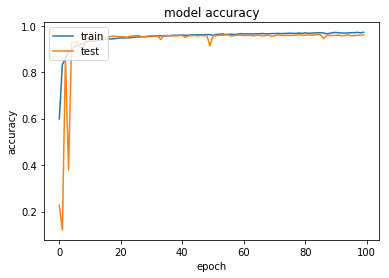

In [24]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

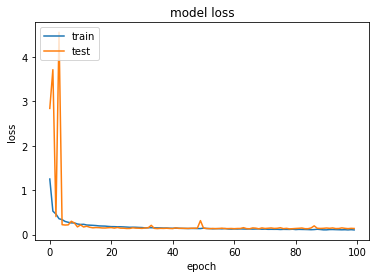

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# history = model.fit_generator(generator=train_generator(batch_size),
#                               steps_per_epoch=np.ceil(23172 / batch_size),
#                               epochs=100,
#                               verbose=1,
#                               #callbacks=callbacks,
#                               validation_data=valid_generator(batch_size),
#                               validation_steps=int(np.ceil(3207/batch_size)))

## submission file

In [27]:
import pandas as pd
df = pd.read_csv('C:\Projects\kaggle\speech\sample_submission\sample_submission.csv')

In [28]:
df.head()

,fname,label
0,clip_000044442.wav,silence
1,clip_0000adecb.wav,silence
2,clip_0000d4322.wav,silence
3,clip_0000fb6fe.wav,silence
4,clip_0001d1559.wav,silence


In [29]:
def dataLoader(x_set, batch_size):

    L = len(x_set)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X=[]
            for wav_name in x_set[batch_start:limit]:
                audio_file = AUDIO_DIR + '/test/audio/'+ wav_name
                wave = librosa.core.load(audio_file, sr=AUDIO_SR)[0]
                X.append(valid_augment(wave))
            X = np.array(X)   
            X = X.reshape(X.shape[0], 99, 161, 1)
            yield X #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [30]:
res_Y=model.predict_generator(dataLoader(df['fname'],100),
                             steps=np.ceil(df.shape[0] / 100))

In [31]:
df['label']=np.argmax(res_Y, axis=1)

In [32]:
# res_classnames=['yes', 'no', 'up', 'down', 'left', 'right', 
#             'on', 'off', 'stop', 'go','silence']
# idx_list = [classnames.index(name) for name in res_classnames]

In [33]:
# idx_list

In [34]:
# def relabel(x):
#     if x in idx_list:
#         return classnames[x]
#     else:
#         return 'unknown'
# df['label']=df['label'].apply(relabel)

In [35]:
df['label']=df['label'].apply(lambda x: AUDIO_NAMES[x])

In [36]:
df.to_csv('vgg8_99x161_val_96_.csv',index=False)

In [37]:
df_Y = pd.DataFrame(res_Y,columns =AUDIO_NAMES)
df_Y.to_csv('vgg8_Y_99x161_val_96_.csv',index=False)